# Classifying with Sorted Spikes

In this tutorial, we will use the classifier to identify the dynamics of the latent position trajectory.

### Set Plotting Defaults

In [1]:
import logging
import os

import matplotlib
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Set background and fontsize
rc_params = {
    'pdf.fonttype': 42, # Make fonts editable in Adobe Illustrator
    'ps.fonttype': 42, # Make fonts editable in Adobe Illustrator
    'axes.labelcolor': '#222222',
    'axes.labelsize': 9,
    'text.color': '#222222',
    'font.sans-serif' : 'Helvetica',
    'text.usetex': False,
    'figure.figsize': (7.2, 4.45),
    'xtick.major.size': 0.00,
    'ytick.major.size': 0.00,
    'axes.labelpad': 0.1,
    }
sns.set(style='white', context='paper', rc=rc_params,
        font_scale=1.0)

# Make analysis reproducible
np.random.seed(0)

# Enable logging
logging.basicConfig(level=logging.INFO)

## Simulate Sorted Spikes Data

First let's simulate some data to train the encoding model on.

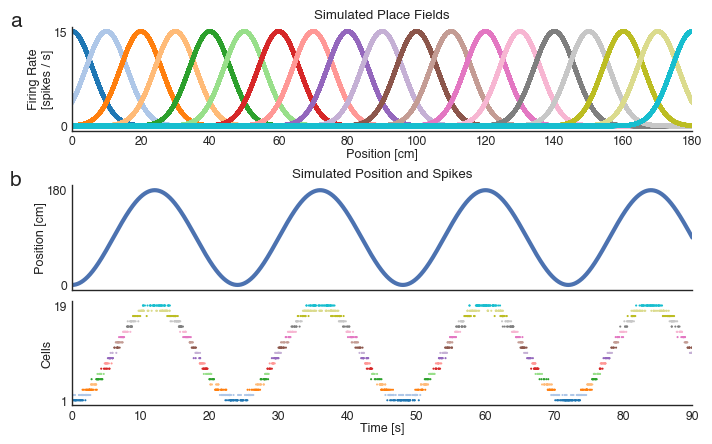

In [2]:
from replay_trajectory_classification.sorted_spikes_simulation import make_simulated_run_data

MM_TO_INCHES = 1.0 / 25.4
TWO_COLUMN = 178.0 * MM_TO_INCHES
GOLDEN_RATIO = (np.sqrt(5) - 1.0) / 2.0

time, linear_distance, sampling_frequency, spikes, place_fields = make_simulated_run_data()
spike_ind, neuron_ind = np.nonzero(spikes)
cmap = plt.get_cmap('tab20')

fig, axes = plt.subplots(3, 1, figsize=(TWO_COLUMN, TWO_COLUMN * GOLDEN_RATIO), constrained_layout=True)
for place_field, color in zip(place_fields.T, cmap.colors):
    axes[0].plot(linear_distance, place_field, linewidth=3, color=color)
axes[0].set_xlabel('Position [cm]')
axes[0].set_ylabel('Firing Rate\n[spikes / s]')
axes[0].set_title('Simulated Place Fields')
axes[0].set_xlim((linear_distance.min(), linear_distance.max()))
axes[0].set_yticks([0, np.round(place_fields.max())])
axes[0].text(-0.10, 1.0, 'a', transform=axes[0].transAxes, 
        size=15, weight='extra bold')

axes[1].plot(time, linear_distance, linewidth=3)
axes[1].set_ylabel('Position [cm]')
axes[1].set_title('Simulated Position and Spikes')
axes[1].set_yticks([0, np.round(linear_distance.max())])
axes[1].set_xticks([])
axes[1].set_xlim((0.0, 90.0))
axes[1].text(-0.10, 1.0, 'b', transform=axes[1].transAxes, 
        size=15, weight='extra bold')

c = [cmap.colors[ind] for ind in neuron_ind]
axes[2].scatter(time[spike_ind], neuron_ind + 1, c=c, s=0.5)
axes[2].set_yticks((1, spikes.shape[1]))
axes[2].set_ylabel('Cells')

axes[2].set_xlabel('Time [s]')
axes[2].set_xlim((0.0, 90.0))

sns.despine()

## Fit Sorted Spikes Classifier

Next we will fit the model on the position and the spikes. This will encode the relationship between spikes and position (aka the place field maps).

The `continuous_transition_types` parameter is a 3x3 matrix (because we have three dynamics: continuous, fragmented, and stationary). This governs how the position will change when in a given dynamic or when transitioning between dynamics.

The `discrete_transition_diag` also creates a transition matrix between dynamics, defining how likely the model is, on average, to stay in the dynamic or change.

In [3]:
from replay_trajectory_classification import (
    SortedSpikesClassifier, Environment, RandomWalk,
    Uniform, Identity, estimate_movement_var)


movement_var = estimate_movement_var(linear_distance, sampling_frequency)

environment = Environment(place_bin_size=np.sqrt(movement_var))
continuous_transition_types = [[RandomWalk(movement_var=movement_var * 120),  Uniform(), Identity()],
                                [Uniform(),                                   Uniform(), Uniform()],
                                [RandomWalk(movement_var=movement_var * 120), Uniform(), Identity()],
                               ]
classifier = SortedSpikesClassifier(
    environments=environment,
    continuous_transition_types=continuous_transition_types,
    sorted_spikes_algorithm='spiking_likelihood_kde',
    sorted_spikes_algorithm_params={'position_std': 3.0,
                                   }
)
# classifier = SortedSpikesClassifier(
#     environments=environment,
#     continuous_transition_types=continuous_transition_types,
#     sorted_spikes_algorithm='spiking_likelihood_glm',
#     sorted_spikes_algorithm_params={'knot_spacing': 10}
# )
classifier.fit(linear_distance, spikes)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting continuous state transition...
INFO:replay_trajectory_classification.classifier:Fitting discrete state transition
INFO:replay_trajectory_classification.classifier:Fitting place fields...


SortedSpikesClassifier(continuous_transition_types=[[RandomWalk(environment_name='',
                                                                movement_var=33.31009971953084,
                                                                movement_mean=0.0,
                                                                use_diffusion=False),
                                                     Uniform(environment_name='',
                                                             environment2_name=None),
                                                     Identity(environment_name='')],
                                                    [Uniform(environment_name='',
                                                             environment2_name=None),
                                                     Uniform(environment_name='',
                                                             environment2_name=None),
                                                     Uniform(...
                       infer_track_interior=True,
                       initial_conditions_type=UniformInitialConditions(),
                       observation_models=(ObservationModel(environment_name='',
                                                            encoding_group=0),
                                           ObservationModel(environment_name='',
                                                            encoding_group=0),
                                           ObservationModel(environment_name='',
                                                            encoding_group=0)),
                       sorted_spikes_algorithm='spiking_likelihood_kde',
                       sorted_spikes_algorithm_params={'position_std': 3.0})

We can plot the place fields.

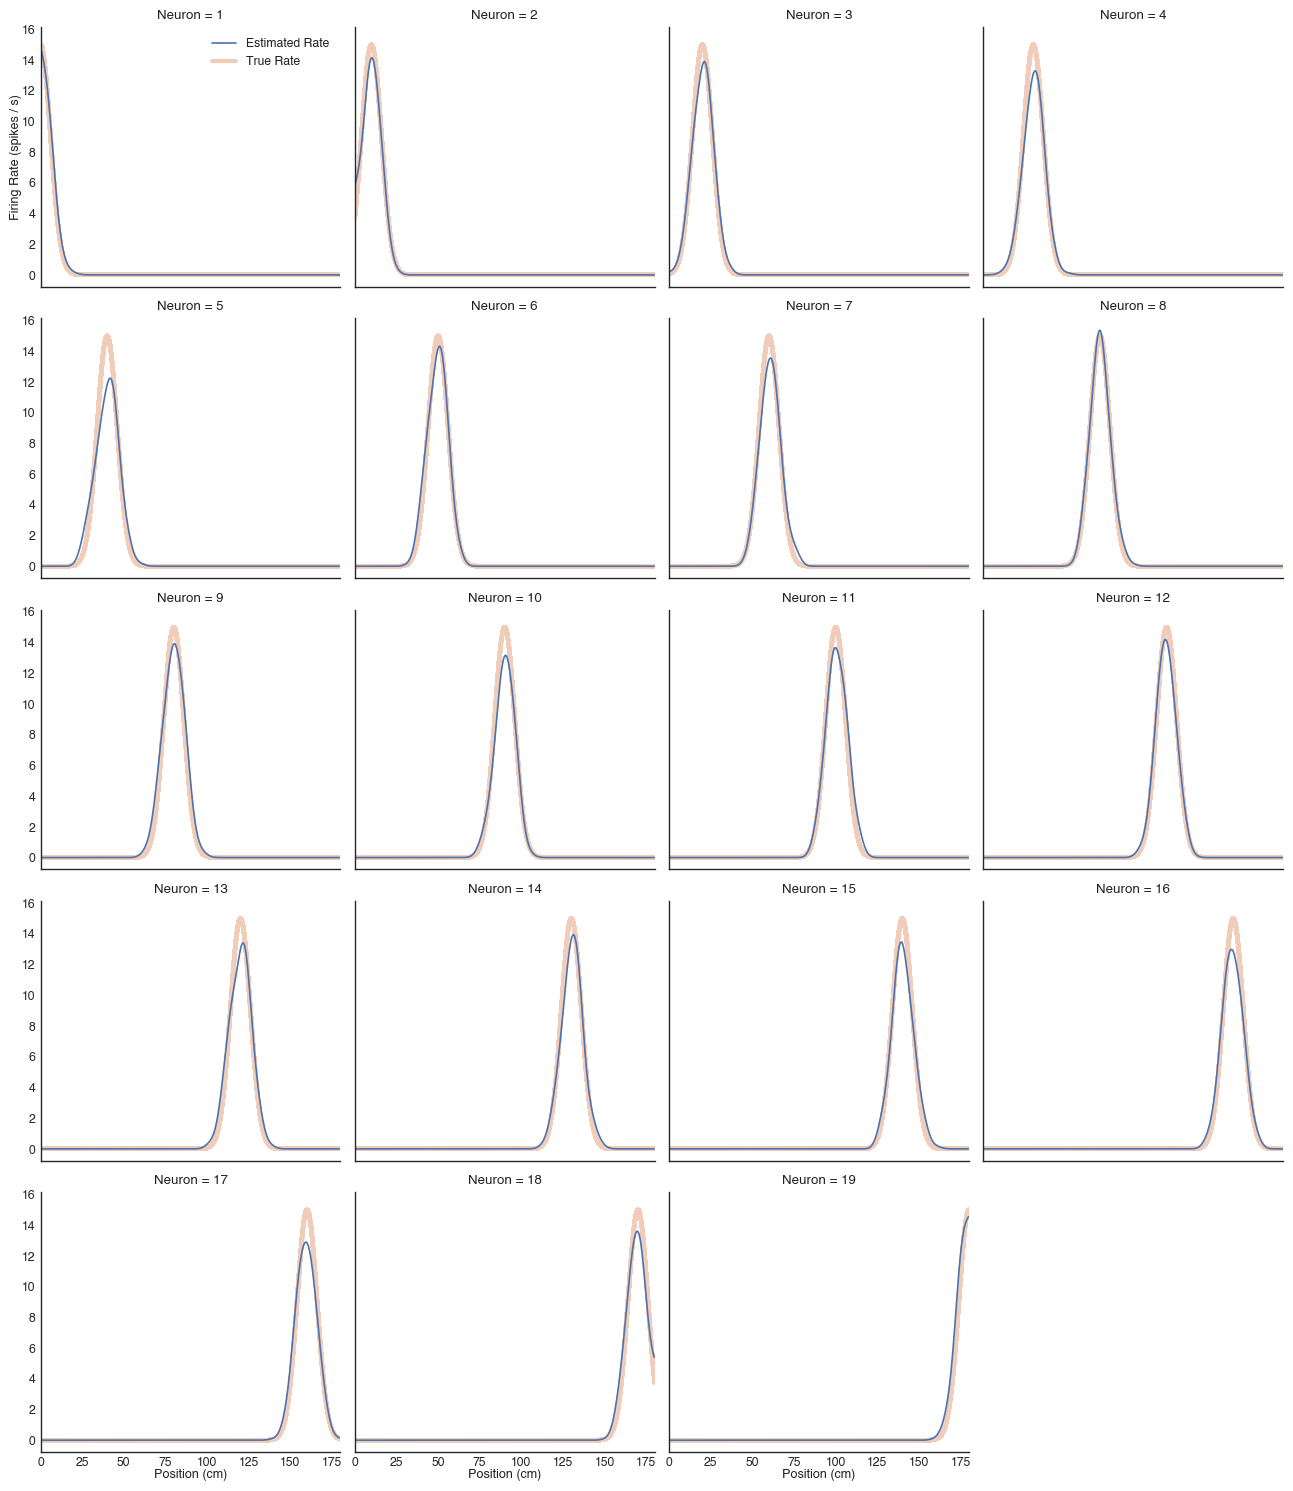

In [4]:
g = (classifier.place_fields_['', 0] * sampling_frequency).plot(x='position', col='neuron', col_wrap=4, label='Estimated Rate')
for ind, (ax, true_field) in enumerate(zip(g.axes.flat, place_fields.T)):
    ax.plot(linear_distance, true_field, linestyle='-',
            zorder=0, linewidth=3, alpha=0.4, label='True Rate')
    ax.set_xlim((linear_distance.min(), linear_distance.max()))
    ax.set_title(f'Neuron = {ind + 1}')
sns.despine()

g.axes[0, 0].set_ylabel('Firing Rate (spikes / s)')
g.axes[0, 0].legend(frameon=False)

for ax in g.axes[-1]:
    ax.set_xlabel('Position (cm)')

After we have fit the model, we can plot transition matrices that were constructed as specified by `continuous_transition_types`.

In [5]:
# fig, axes = plt.subplots(3, 3, figsize=(9, 9),
#                          sharex=True, sharey=True,
#                          constrained_layout=True)
# continuous_transition_types = np.asarray(classifier.continuous_transition_types)
# x, y = np.meshgrid(environment.place_bin_edges_, environment.place_bin_edges_)
# state_names = ['continuous', 'fragmented', 'stationary']
# bin_min, bin_max = linear_distance.min(), linear_distance.max()

# for j in range(3):
#     for k in range(3):
#         im = axes[j, k].pcolormesh(x, y, classifier.continuous_state_transition_[j, k], cmap='Blues',
#                                    vmin=0.0, vmax=classifier.continuous_state_transition_[j, k].max())
#         # axes[j, k].text(1, 175, continuous_transition_types[j, k].replace('_', ' '), color='grey',
#         #                 va='top', fontsize=14)
#         axes[j, k].set_title(f'{state_names[j]} → {state_names[k]}')
#         axes[j, k].set_xticks((bin_min, bin_max))
#         axes[j, k].set_yticks((bin_min, bin_max))
        
# plt.xlim((bin_min, bin_max))
# plt.ylim((bin_min, bin_max))
# axes[1, 0].set_ylabel(r'$position_{t-1}$')
# axes[-1, 1].set_xlabel(r'$position_{t}$')
# plt.suptitle('Continuous State Transition', y=1.04, fontsize=22)
# cbar = fig.colorbar(im, ax=axes.ravel().tolist(), ticks=[0, 1], label='Probability')
# cbar.ax.set_yticklabels(['0', 'Max'])
# sns.despine()

We can also plot the transition matrix between the dynamics

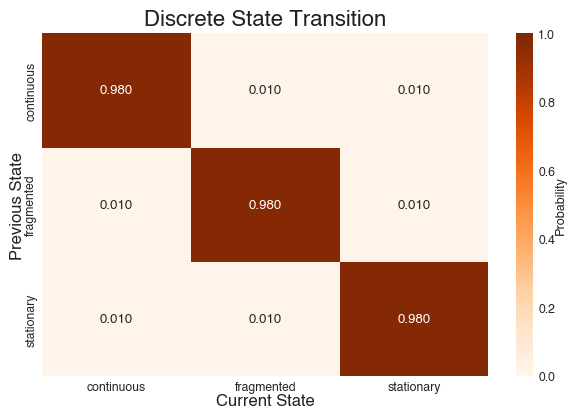

In [6]:
state_names = ['continuous', 'fragmented', 'stationary']
classifier.plot_discrete_state_transition(state_names)

## Test classifier on different replay types 

Now we can see how this model works on different types of replay dynamics

In [7]:
STATE_COLORS = {
    'stationary': '#9f043a',
    'fragmented': '#ff6944',
    'continuous': '#521b65',
    'stationary-continuous-mix': '#61c5e6',
    'fragmented-continuous-mix': '#2a586a',
    '': '#c7c7c7',
}

def plot_classification(replay_time, test_spikes, results):
    fig, axes = plt.subplots(3, 1, figsize=(10, 6), constrained_layout=True, sharex=True)
    spike_time_ind, neuron_ind = np.nonzero(test_spikes)
    axes[0].scatter(replay_time[spike_time_ind], neuron_ind, color='black', zorder=1,
                    marker='|', s=80, linewidth=3)
    axes[0].set_yticks((0, test_spikes.shape[1]))
    axes[0].set_ylabel('Neuron Index')
    replay_probabilities = results.groupby("state").sum().acausal_posterior
    for state in replay_probabilities.state.values:
        replay_probabilities.sel(state=state).plot(x='time', color=STATE_COLORS[state], linewidth=3,
                         ax=axes[1], label=state)
    axes[1].set_ylabel('Probability')
    axes[1].set_yticks([0, 1])
    axes[1].set_ylim((-0.01, 1.05))
    axes[1].legend(bbox_to_anchor=(1.15, 0.95), loc='upper right', fancybox=False, shadow=False,
                   ncol=1, frameon=False)
    
    results.acausal_posterior.groupby("position").sum().plot(
        x='time', y='position', robust=True, vmin=0.0, ax=axes[2])
    axes[2].set_ylabel('Position [cm]')
    plt.xlim((replay_time.min(), replay_time.max()))
    axes[-1].set_xlabel('Time [ms]')
    sns.despine()

### Continuous

INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/19 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


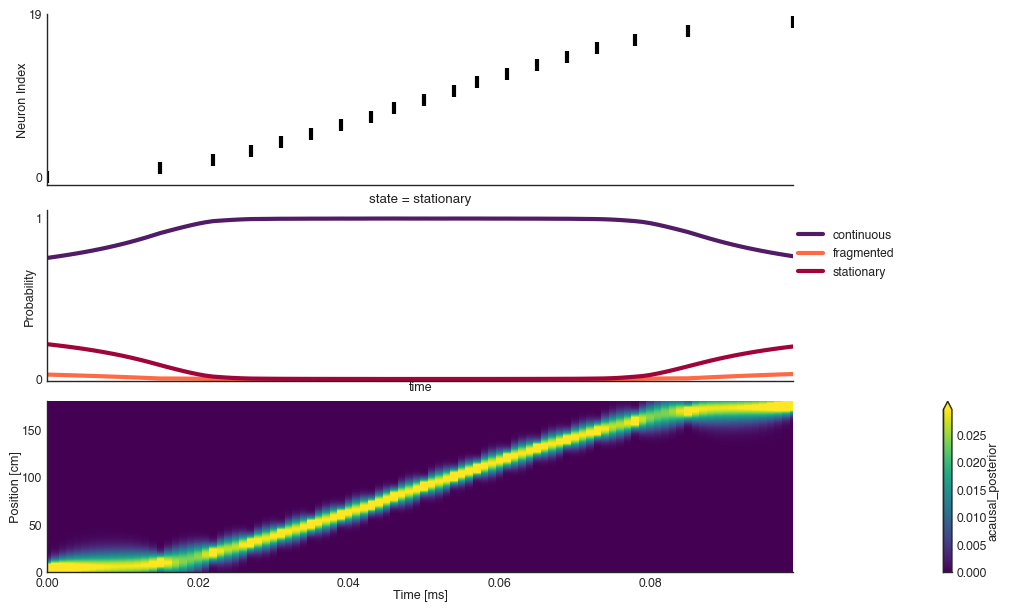

In [8]:
from replay_trajectory_classification.sorted_spikes_simulation import make_continuous_replay

replay_time, test_spikes = make_continuous_replay()
state_names = ['continuous', 'fragmented', 'stationary']
results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)

### Stationary

INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/19 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


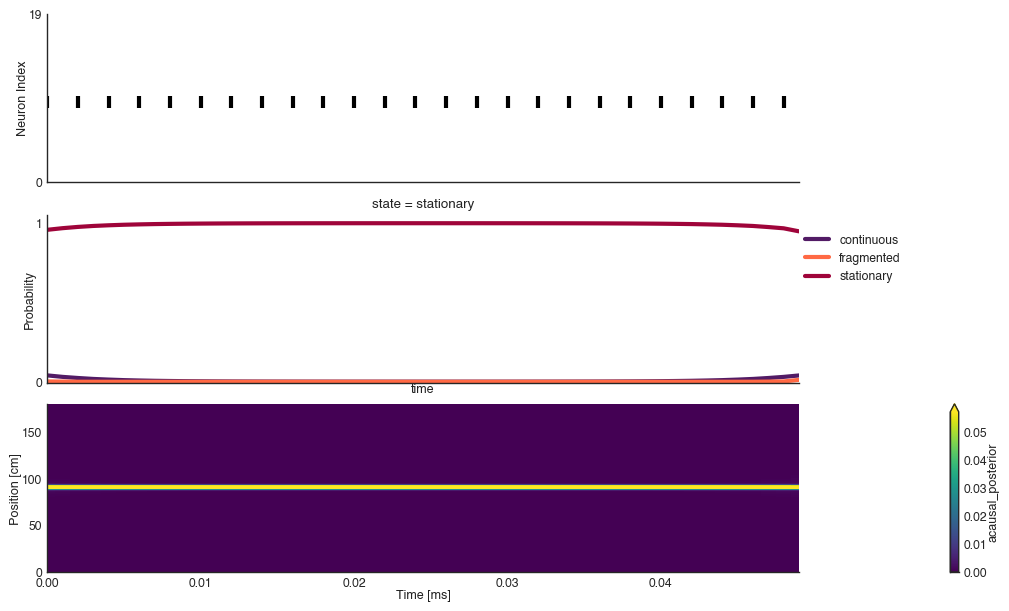

In [9]:
from replay_trajectory_classification.sorted_spikes_simulation import make_hover_replay

replay_time, test_spikes = make_hover_replay()

results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)

### Fragmented

INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/19 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


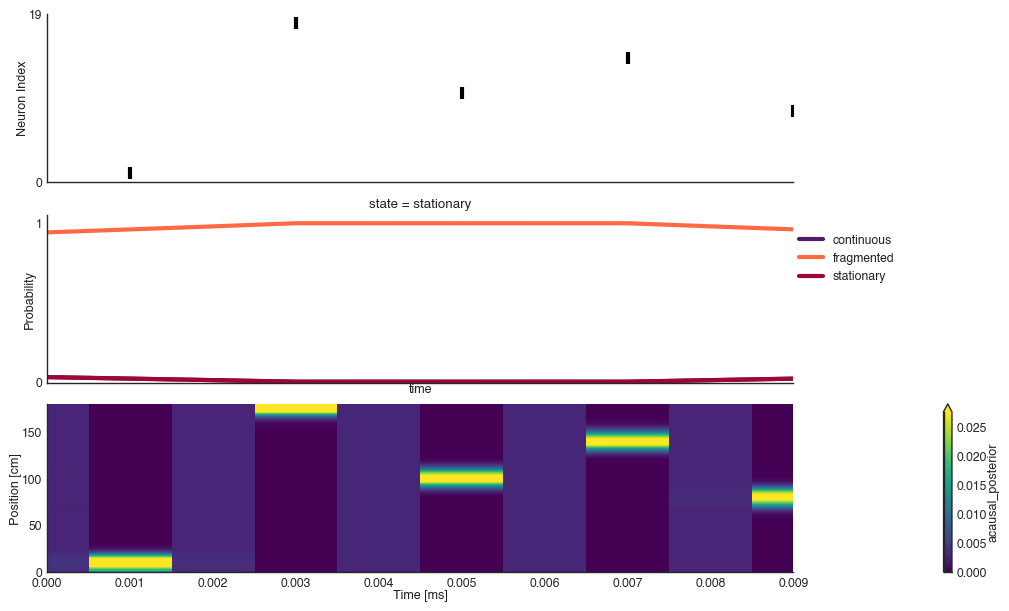

In [10]:
from replay_trajectory_classification.sorted_spikes_simulation import make_fragmented_replay

replay_time, test_spikes = make_fragmented_replay()

results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)

### Stationary-Continuous-Stationary

INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/19 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


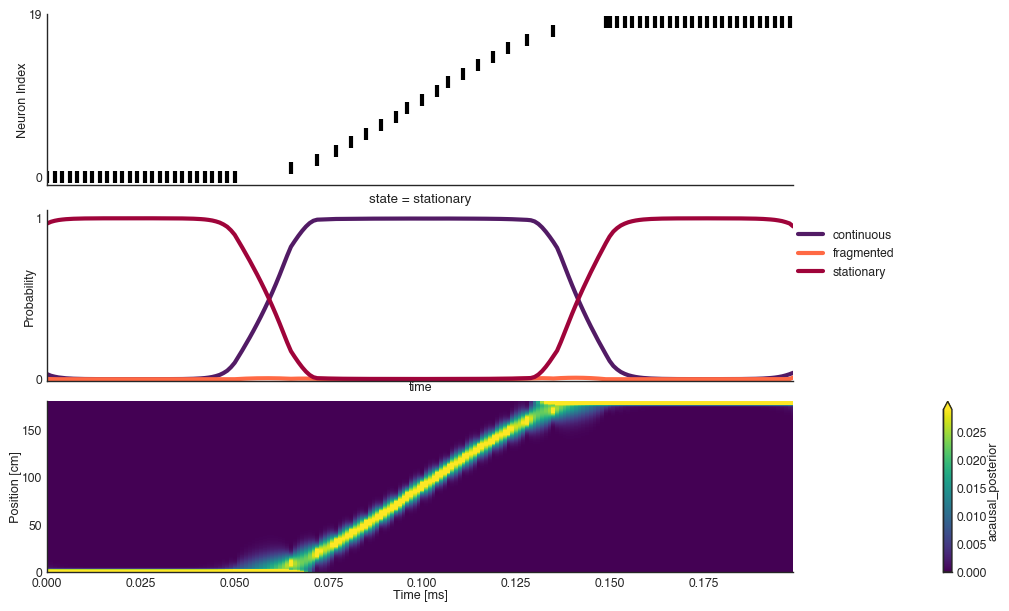

In [11]:
from replay_trajectory_classification.sorted_spikes_simulation import make_hover_continuous_hover_replay

replay_time, test_spikes = make_hover_continuous_hover_replay()

results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)

### Fragmented-Stationary-Fragmented

INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/19 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


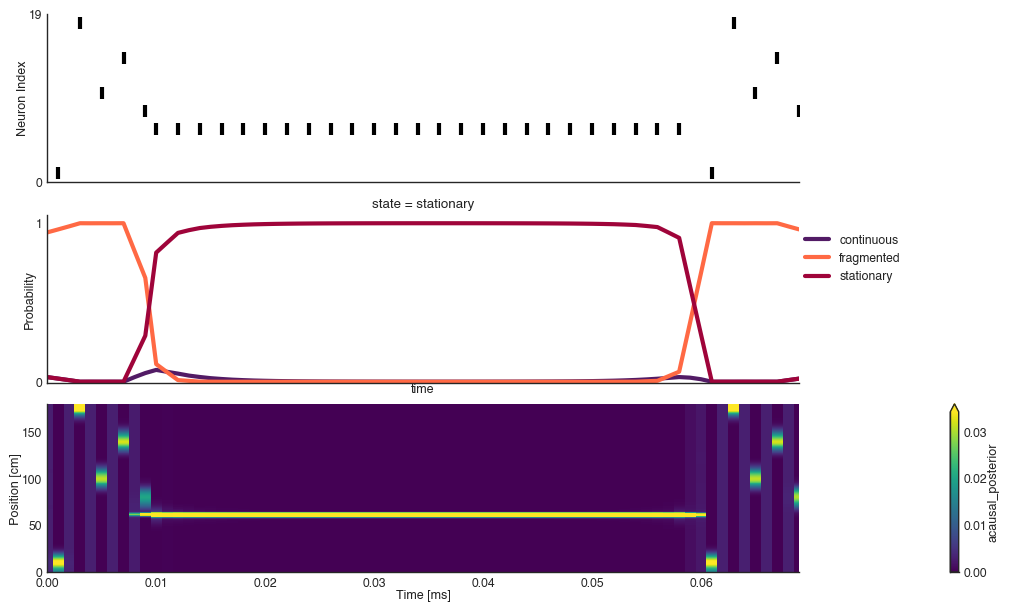

In [12]:
from replay_trajectory_classification.sorted_spikes_simulation import make_fragmented_hover_fragmented_replay

replay_time, test_spikes = make_fragmented_hover_fragmented_replay()

results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)

### Fragmented-Continuous-Fragmented

INFO:replay_trajectory_classification.classifier:Estimating likelihood...


  0%|          | 0/19 [00:00<?, ?it/s]

INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


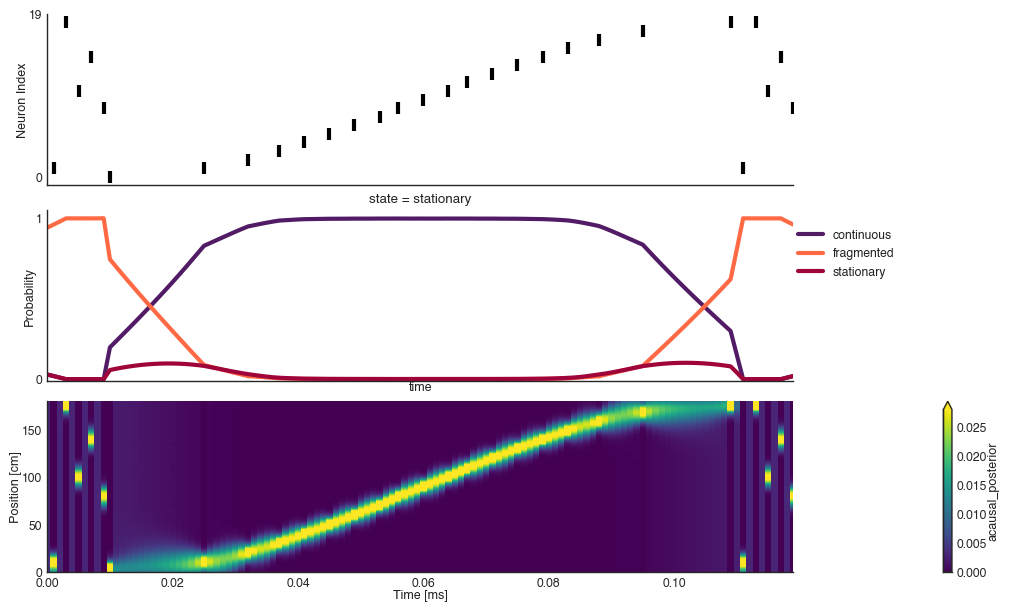

In [13]:
from replay_trajectory_classification.sorted_spikes_simulation import make_fragmented_continuous_fragmented_replay

replay_time, test_spikes = make_fragmented_continuous_fragmented_replay()

results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)